# Шумы и их удаление
В данной работе демонстрируется добавление случайного шума и шума типа "соль-перец", а также удаление их с изображения с помощью срединного и медианного фильтров.

Для начала импортируем все необходимые пакеты для работы, а также две функции - пороговую функцию и функцию оконного применения, которые мы реализовывали ранее.

In [1]:
import numpy as np
%matplotlib inline
import reader
import grapher
from analysis.preprocessing import step_function, apply_under_matrix

Прочтем и отобразим исходное изображение и информацию о нем. Нормализовывать изображение не будем для корректного отображения фона.

Image shape:  (300, 400)


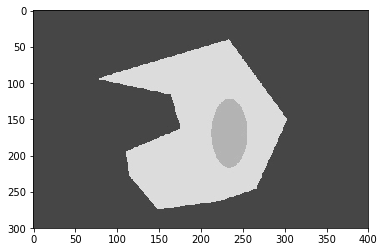

In [2]:
col_num, row_num, depth, image_data = reader.jpg_reader("data/MODEL.jpg", channels=1)
print('Image shape: ', image_data.shape)
grapher.set_image(image_data, cmap="gray", normalize=False)

Далее создадим функцию для добавления шума на изображение. Функция на вход принимает массив данных, тип добавляемого шума (случайный или "соль-перец"), частоту, а также для случайного шума - максимальный размер добавляемого искажения.

In [3]:
def add_noise(data: np.ndarray, type: str, sparsity: float = 0.1, random_size=30) -> np.ndarray:
	if type == "random":
		__noise = lambda x: x if np.random.rand(1) > sparsity else x + np.random.randint(-1, 2) * np.random.randint(1, random_size)
	elif type == "s&p":
		__noise = lambda x: x if np.random.rand(1) > sparsity else np.random.choice([0, 255])
	else:
		raise ValueError("Unknown noise type, available types: random, s&p")
	__noise = np.vectorize(__noise)
	data = __noise(data)
	data = step_function(data, 0, 255, 8)
	return data

Добавим случайный шум на изначальное изображение и отобразим его.

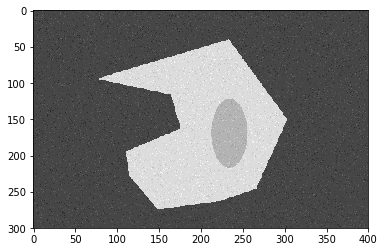

In [4]:
randnoise_data = add_noise(image_data, "random", sparsity=0.25)
grapher.set_image(randnoise_data, cmap="gray", normalize=False)

Аналогично шум "соль-перец".

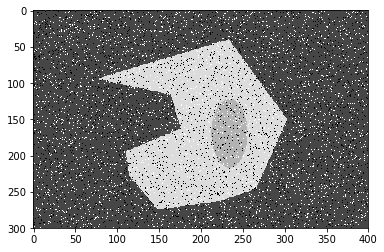

In [5]:
spnoise_data = add_noise(image_data, "s&p", sparsity=0.1)
grapher.set_image(spnoise_data, cmap="gray")

Далее реализуем и применим срединный фильтр.
Для применения будем использовать уже созданную процедуру, которая идет "окном" по данным и в зависимости от значения центрального пикселя применяет некую функцию ко всему окну. В качестве фильтра будет выступать функция, которая складывает все значения массива и делит их на длину массива, т.о. записывая в окно среднее значение.

In [6]:
filter_size = 3
filter = lambda arr: int(np.sum(arr) / (filter_size ** 2))

Применим данный фильтр к зашумленному изображению, в качестве активационной функции указав константное True (т.к. мы хотим зашумить все)

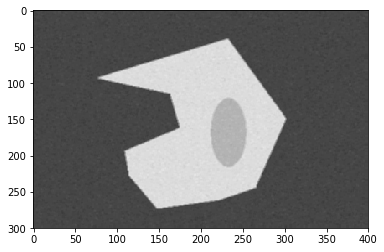

In [7]:
average_randnoise_data = apply_under_matrix(randnoise_data, filter_size, lambda x: True, filter)
grapher.set_image(average_randnoise_data, cmap="gray", normalize=False)

Как видим, срединный фильтр вполне неплохо справился с случайным шумом, хоть и не убрал его до конца. Фильтр можно усилить, увеличив размер окна, но тогда изображение будет более расплывчатым.  
Применим этот же фильтр к шуму "соль-перец".

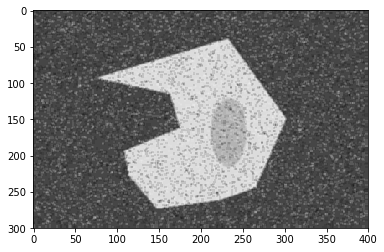

In [8]:
average_spnoise_data = apply_under_matrix(spnoise_data, filter_size, lambda x: True, filter)
grapher.set_image(average_spnoise_data, cmap="gray", normalize=False)

Как можно заметить, срединный фильтр плохо справляется с шумом типа "соль-перец", т.к. зашумленные точки являются очень большими выбросами, что влияет на вычисление среднего элемента.  
Далее реализуем медианный фильтр. Данный фильтр сортирует все значения окна и выбирает среднее, таким образом, получая наиболее вероятное значение пикселя при равномерном или обширном заполнении.

In [9]:
filter = lambda arr: sorted(list(arr.flat))[(filter_size ** 2) // 2 + 1]

Аналогичным образом применим его к случайному шуму.

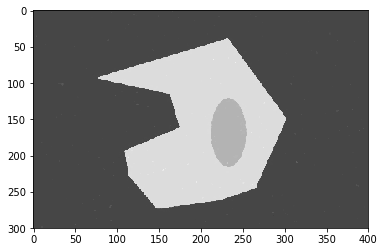

In [10]:
average_randnoise_data = apply_under_matrix(randnoise_data, filter_size, lambda x: True, filter)
grapher.set_image(average_randnoise_data, cmap="gray", normalize=False)

Как можно заметить, фильтр практически полностью убрал случайный шум с изображения.  
Примением его же к шуму типа "соль-перец".

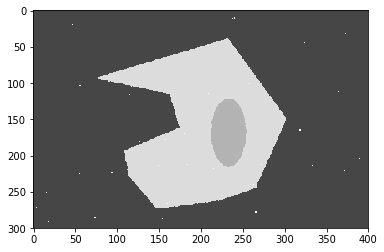

In [11]:
average_spnoise_data = apply_under_matrix(spnoise_data, filter_size, lambda x: True, filter)
grapher.set_image(average_spnoise_data, cmap="gray", normalize=False)

Получившееся изображение также почти совсем очищено от шума, однако в некоторых местах шум остался. Это значит что шум наложился таким образом, что в рамках нашего размера фильтра составляет более половины полезной информации. Если полученный результат нас не устраивает, мы можем увеличить размер фильтра...

In [12]:
filter_size = 7

...и применить его к изображению, ...

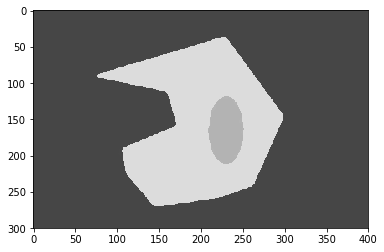

In [13]:
average_spnoise_data = apply_under_matrix(average_spnoise_data, filter_size, lambda x: True, filter)
grapher.set_image(average_spnoise_data, cmap="gray", normalize=False)

...однако границы полученного изображения будут меняться и станут очень рваным и неровными.